In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
import plotly.express as px, plotly.graph_objects as go
import missingno as msno

In [49]:
import pandas as pd
import numpy as np

RAW_FILE = "city_day.csv"          # path to the attachment
OUT_FILE = "city_day_clean.csv"

# Low-memory load ─ treat empty strings, dots, dashes as NaN
na_vals = ["", " ", "-", "nan", "NaN"]
df = pd.read_csv(
    RAW_FILE,
    na_values=na_vals,
    parse_dates=["Date"],
    dayfirst = True,            # change if your file is DD-MM-YYYY
    low_memory=False,
)

print("Raw shape:", df.shape)
display(df.head())

Raw shape: (29531, 16)


,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
1,Ahmedabad,2015-01-02,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2,Ahmedabad,2015-01-03,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
3,Ahmedabad,2015-01-04,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
4,Ahmedabad,2015-01-05,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN


In [50]:
# Strip/standardise column names
df.columns = (
    df.columns.str.strip()
              .str.lower()
              .str.replace(r"[^\w]+", "_", regex=True)
              .str.strip("_")
)

# Numeric columns (everything except 'city', 'date', 'aqi_bucket')
numeric_cols = df.columns.difference(["city", "date", "aqi_bucket"])
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")

# Remove physically impossible negatives
df[numeric_cols] = df[numeric_cols].mask(df[numeric_cols] < 0)

# Replace zeroes where they’re clearly “missing” (e.g., pollutants that can’t
# really be exactly 0 for a whole day).  Keep genuine zeroes for AQI.
cols_where_zero_is_missing = numeric_cols.difference(["aqi"])
df[cols_where_zero_is_missing] = df[cols_where_zero_is_missing].replace(0, np.nan)

# Drop rows with no useful sensor data at all
sensor_cols = numeric_cols.difference(["aqi", "aqi_bucket"])
df = df.dropna(subset=sensor_cols, how="all")

# Impute remaining single missing values with city-level daily medians
df[sensor_cols] = df.groupby("city")[sensor_cols] \
                    .transform(lambda s: s.fillna(s.median()))

# De-duplicate: keep the first occurrence (they’re identical after cleaning)
df = (
    df.drop_duplicates(subset=["city", "date"])
      .sort_values(["city", "date"])
      .reset_index(drop=True)
)

# Quick audit
nulls = df.isna().mean().mul(100).round(1)
print("\nPercentage missing per column after cleaning:")
display(nulls.sort_values())



Percentage missing per column after cleaning:


city           0.0
date           0.0
pm2_5          0.0
no             0.0
no2            0.0
co             0.0
so2            0.0
o3             0.6
nox            3.4
nh3            5.2
pm10           7.3
aqi_bucket     8.8
aqi            8.8
benzene        9.0
toluene       13.2
xylene        45.5
dtype: float64

In [51]:
df.to_csv(OUT_FILE, index=False)
print(f"\nTidy file saved to {OUT_FILE}  |  Final shape: {df.shape}")


Tidy file saved to city_day_clean.csv  |  Final shape: (27192, 16)


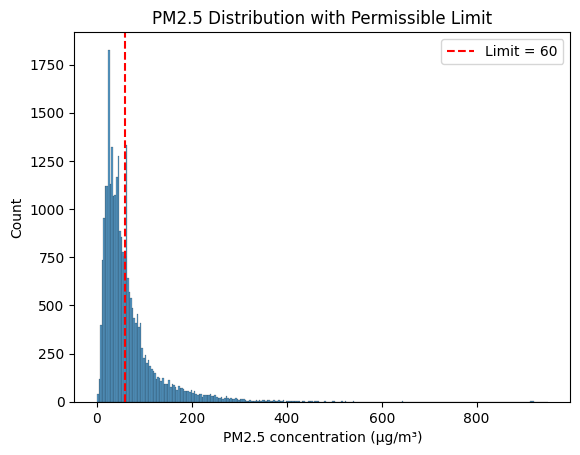

PM2.5 exceeded 60 µg/m³ 39.04% of the time.


In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot histogram for PM2.5
sns.histplot(df['pm2_5'].dropna())  # dropna() to avoid errors with missing values

# Draw vertical line at x=60 (permissible limit)
plt.axvline(x=60, color='red', linestyle='--', label='Limit = 60')

plt.xlabel('PM2.5 concentration (µg/m³)')
plt.ylabel('Count')
plt.title('PM2.5 Distribution with Permissible Limit')
plt.legend()
plt.show()

pm25_cross_pct = (df['pm2_5'] > 60).mean() * 100
print(f"PM2.5 exceeded 60 µg/m³ {pm25_cross_pct:.2f}% of the time.")

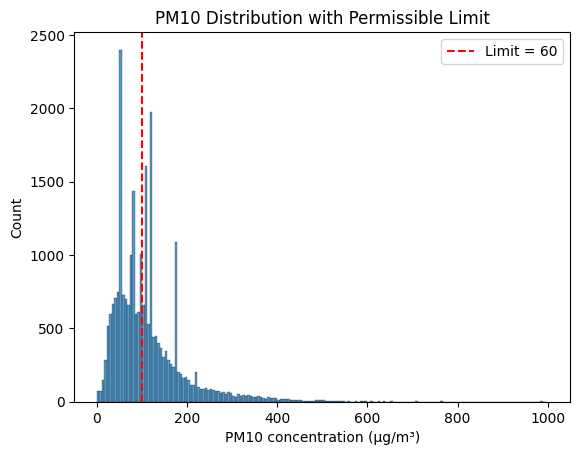

PM10 exceeded 100 µg/m³ 45.09% of the time.


In [53]:
# Histogram for PM10
sns.histplot(df['pm10'].dropna())
plt.axvline(x=100, color='red', linestyle='--', label='Limit = 60')

plt.xlabel('PM10 concentration (µg/m³)')
plt.ylabel('Count')
plt.title('PM10 Distribution with Permissible Limit')
plt.legend()
plt.show()

# Percentage calculation
pm10_cross_pct = (df['pm10'] > 100).mean() * 100
print(f"PM10 exceeded 100 µg/m³ {pm10_cross_pct:.2f}% of the time.")

NO2 exceeded 40 µg/m³ 21.48% of the time.


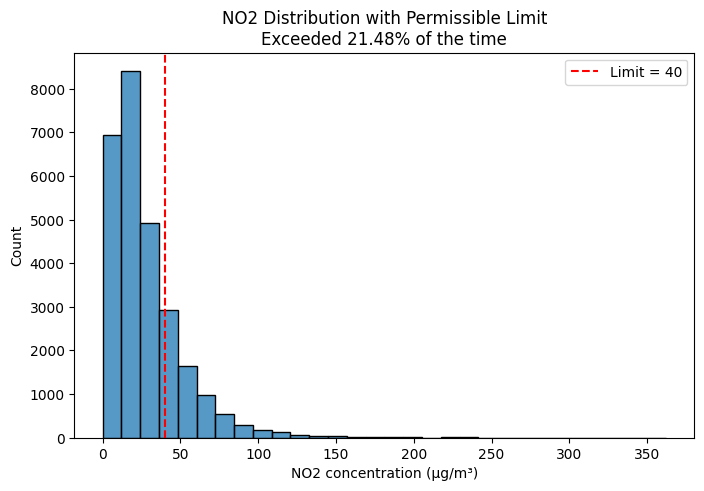

SO2 exceeded 20 µg/m³ 17.10% of the time.


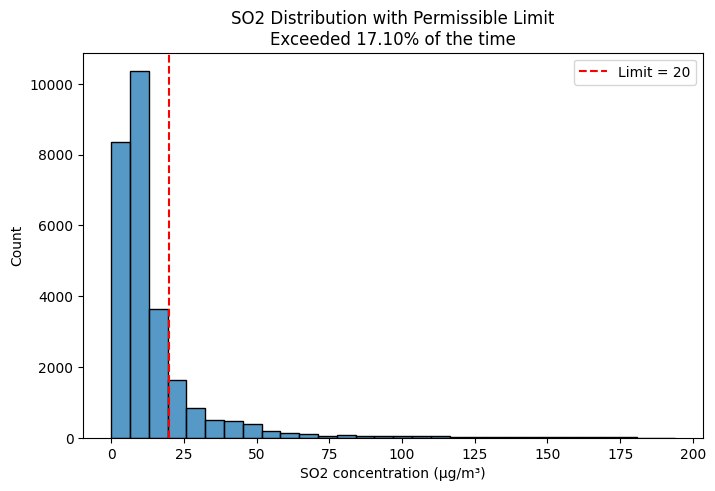

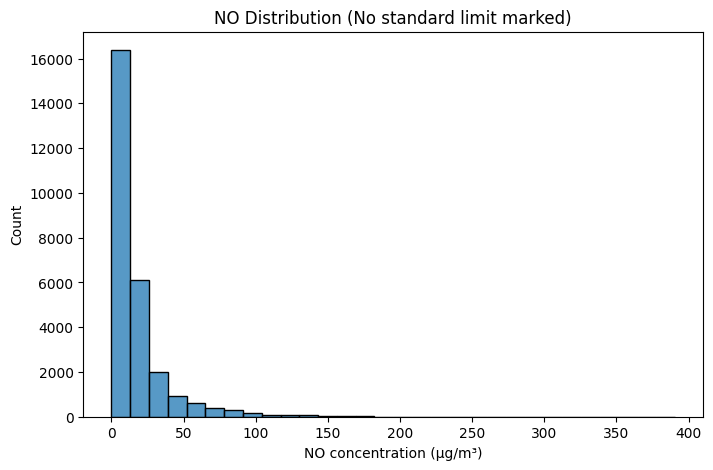

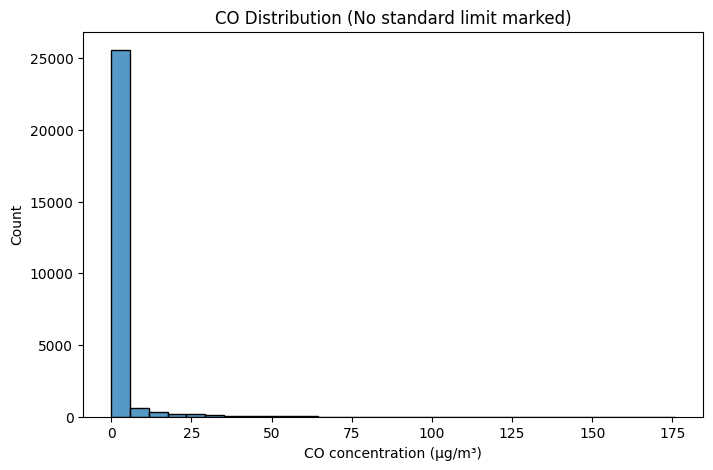

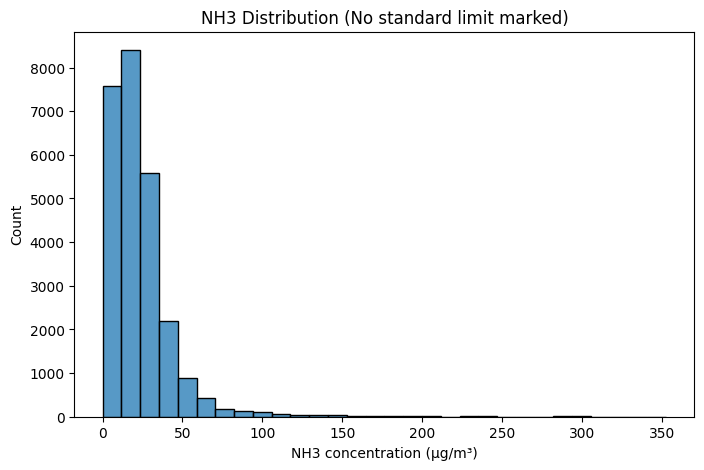

O3 exceeded 100 µg/m³ 1.24% of the time.


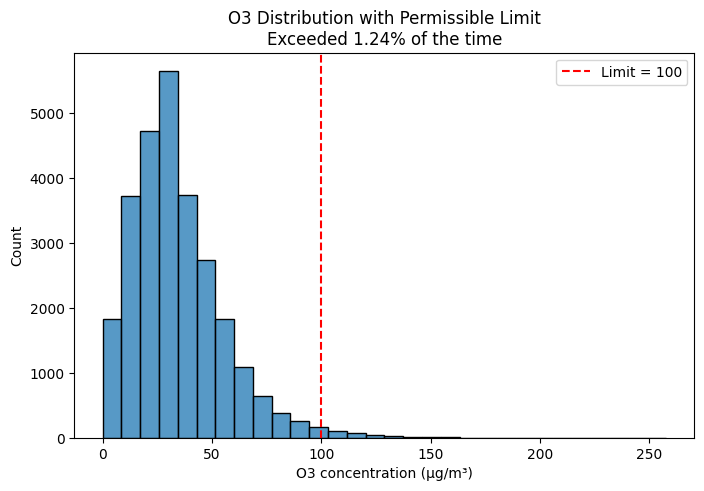

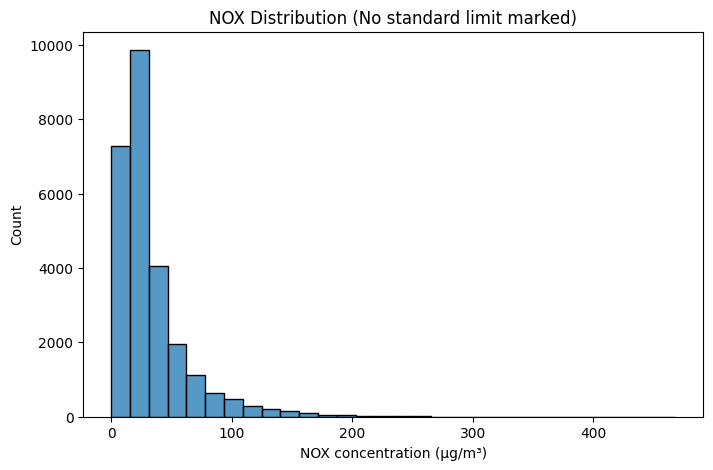

BENZENE exceeded 5 µg/m³ 11.82% of the time.


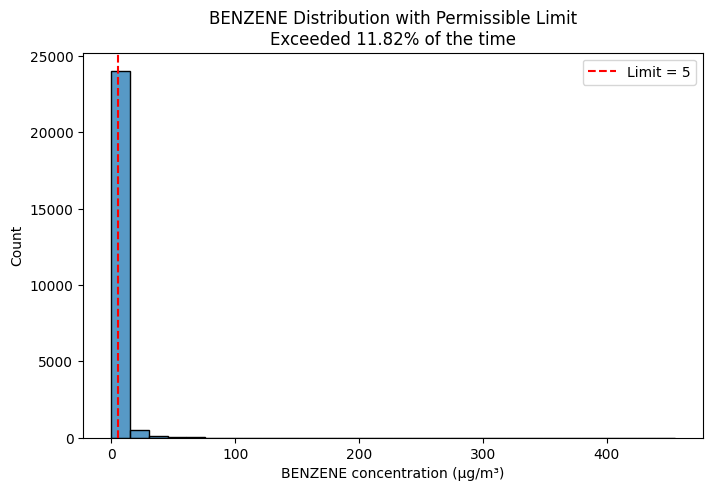

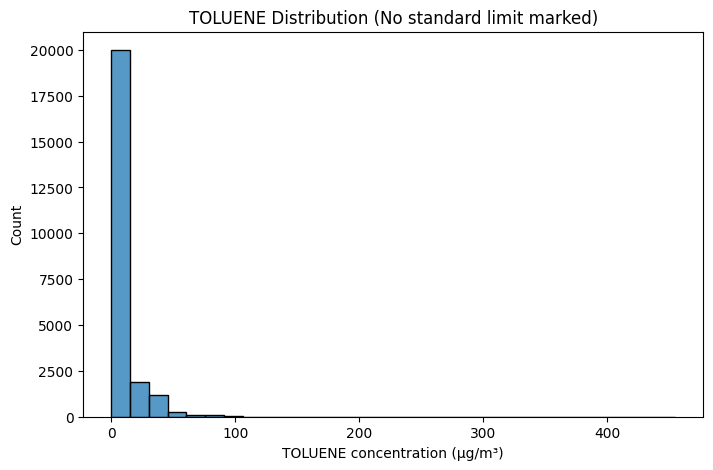

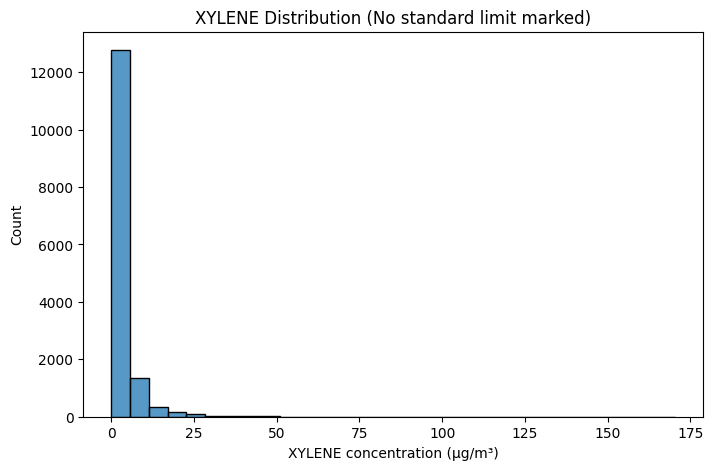

In [54]:
pollutant_limits = {
     "no2": 40,       
    "so2": 20,       
    "no": None,    
    "co": None,       
    "nh3": None,     
    "o3": 100,      
    "nox": None,     
    "benzene": 5,    
    "toluene": None, 
    "xylene": None,  
}

for pollutant, limit in pollutant_limits.items():
    # Check if pollutant exists in df and has data
    if pollutant in df.columns and df[pollutant].notna().any():
        plt.figure(figsize=(8,5))
        sns.histplot(df[pollutant].dropna(), bins=30, kde=False)
        
        if limit is not None:
            plt.axvline(x=limit, color='red', linestyle='--', label=f'Limit = {limit}')
            exceed_pct = (df[pollutant] > limit).mean() * 100
            plt.title(f"{pollutant.upper()} Distribution with Permissible Limit\nExceeded {exceed_pct:.2f}% of the time")
            print(f"{pollutant.upper()} exceeded {limit} µg/m³ {exceed_pct:.2f}% of the time.")
        else:
            plt.title(f"{pollutant.upper()} Distribution (No standard limit marked)")
        
        plt.xlabel(f'{pollutant.upper()} concentration (µg/m³)')
        plt.ylabel('Count')
        if limit is not None:
            plt.legend()
        plt.show()

In [55]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
print(df['date'].isna().sum(), "rows have invalid dates")

0 rows have invalid dates


In [56]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['month_name'] = df['date'].dt.strftime('%b')  # e.g., Jan, Feb ...
monthly_avg = df.groupby(['city', 'year', 'month'])[numeric_cols].mean().reset_index()

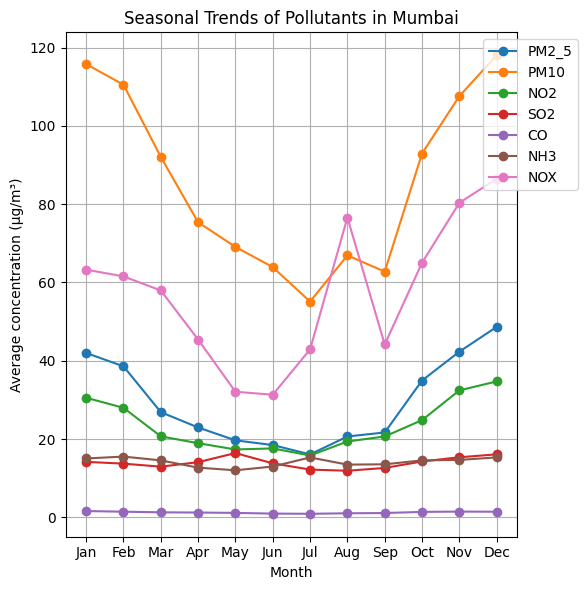

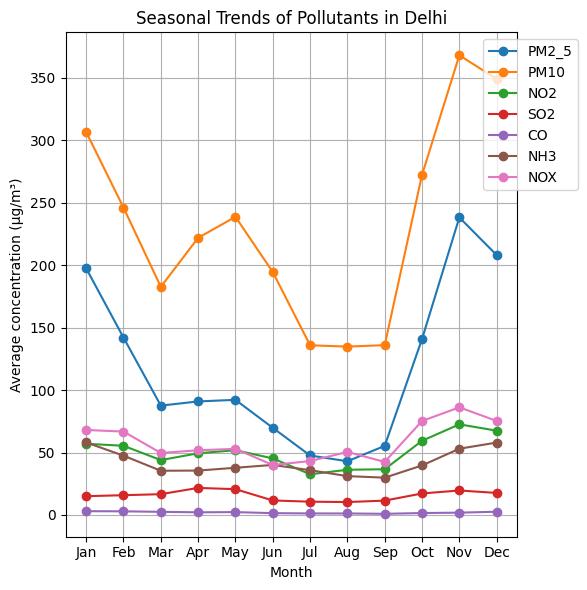

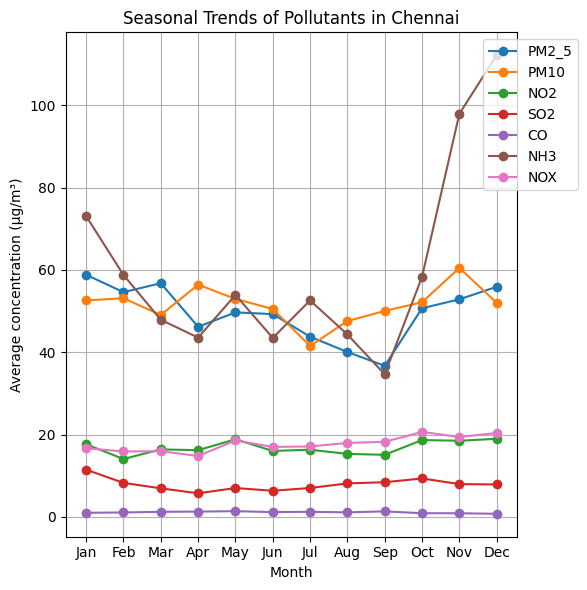

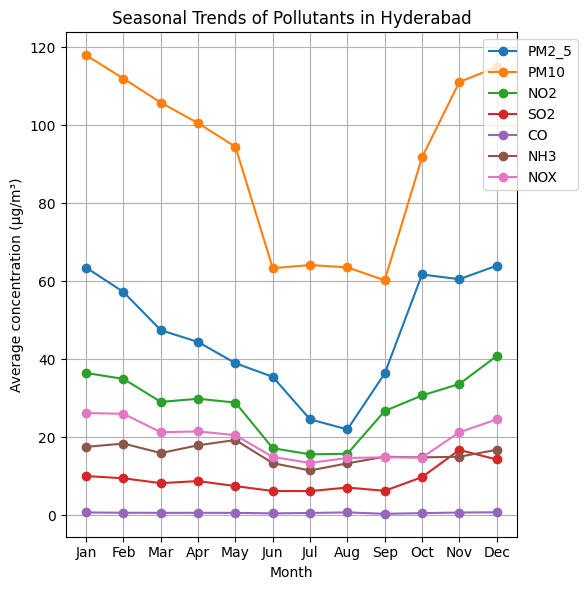

In [57]:
pollutants = ['pm2_5', 'pm10', 'no2', 'so2', 'co', 'nh3', 'nox']

# Cities of interest
cities = ['Mumbai', 'Delhi', 'Chennai', 'Hyderabad']

for city in cities:
    plt.figure(figsize=(6,6))
    city_data = monthly_avg[monthly_avg['city'].str.lower() == city.lower()]  # case insensitive match

    for pollutant in pollutants:
        if pollutant in city_data.columns:
            # Average over all years for each month
            month_means = city_data.groupby('month')[pollutant].mean()
            plt.plot(month_means.index, month_means.values, marker='o', label=pollutant.upper())

    plt.xticks(ticks=range(1,13), labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
    plt.xlabel('Month')
    plt.ylabel('Average concentration (µg/m³)')
    plt.title(f'Seasonal Trends of Pollutants in {city}')
    plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [58]:
import ipywidgets as widgets
from IPython.display import display
import plotly.express as px
import pandas as pd

# Assuming your df is already loaded and cleaned, with 'date' parsed as datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

cities = df['city'].unique()
pollutants = ['pm2_5', 'pm10', 'no2', 'so2', 'co']

city_widget = widgets.Dropdown(options=cities, description='City:')
pollutant_widget = widgets.Dropdown(options=pollutants, description='Pollutant:')

def plot_air_quality(city, pollutant):
    filtered_df = df[(df['city'] == city) & (df[pollutant].notna())]
    fig = px.line(filtered_df, x='date', y=pollutant,
                  title=f'{pollutant.upper()} Levels Over Time in {city}',
                  labels={pollutant: f'{pollutant.upper()} Concentration (µg/m³)', 'date': 'Date'})
    fig.show()

ui = widgets.HBox([city_widget, pollutant_widget])
out = widgets.interactive_output(plot_air_quality, {'city': city_widget, 'pollutant': pollutant_widget})

display(ui, out)


Output()

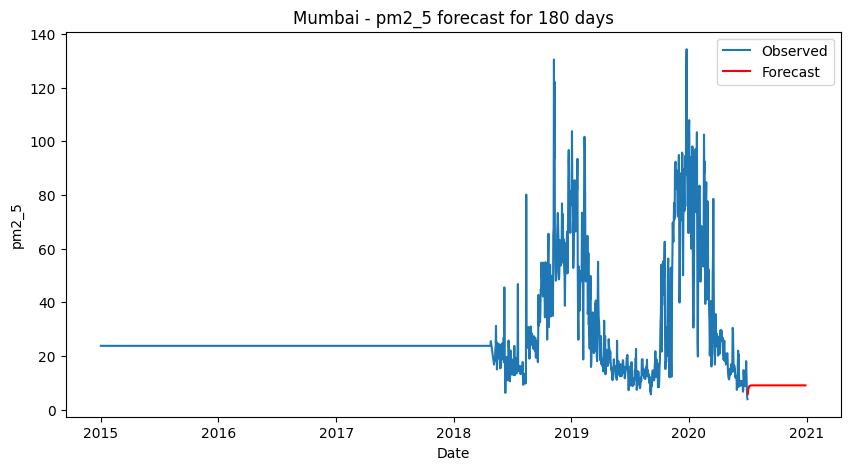

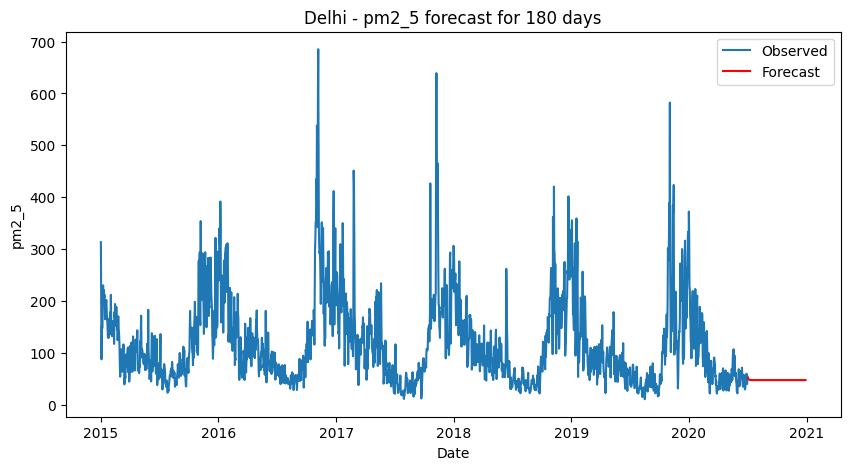

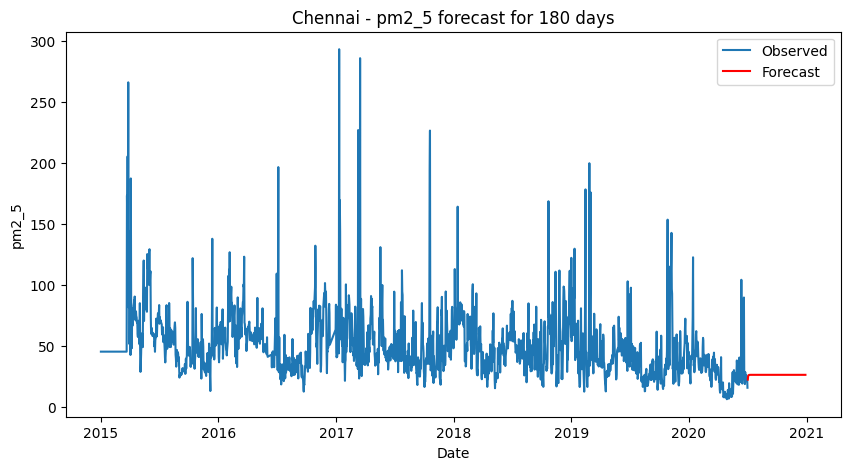

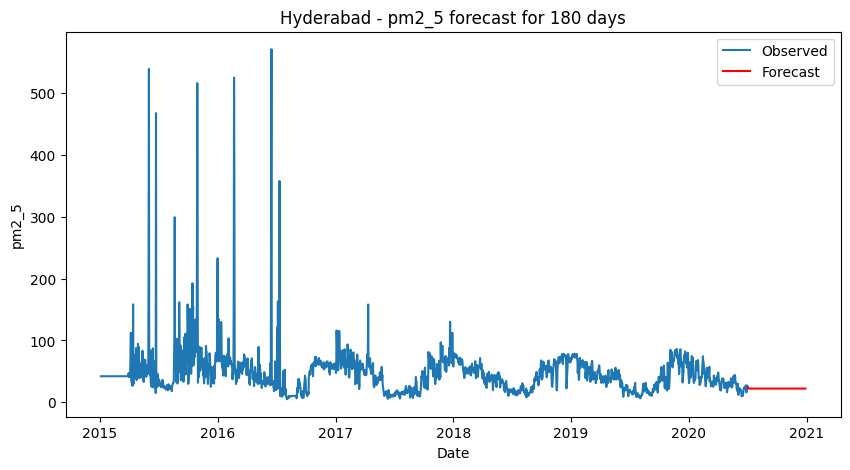

In [67]:
from statsmodels.tsa.arima.model import ARIMA
import warnings

warnings.filterwarnings("ignore")

# Keep original df intact
df_copy = df.copy()

# Ensure 'date' is datetime and sorted
df_copy['date'] = pd.to_datetime(df_copy['date'])
df_copy = df_copy.sort_values(['city', 'date'])

# --------------------
# Forecast setup
# --------------------
forecast_horizon = 180
target_column = 'pm2_5'
cities = ['Mumbai', 'Delhi', 'Chennai', 'Hyderabad']

for city in cities:
    city_data = df_copy[df_copy['city'] == city][['date', target_column]].dropna()

    if city_data.empty:
        print(f"[{city}] No rows for this city -> skipping")
        continue

    # Set date as index
    city_data = city_data.set_index('date')

    try:
        # Fit ARIMA
        model = ARIMA(city_data[target_column], order=(1, 1, 1))
        model_fit = model.fit()

        # Forecast
        forecast = model_fit.forecast(steps=forecast_horizon)
        forecast_index = pd.date_range(
            start=city_data.index[-1] + pd.Timedelta(days=1),
            periods=forecast_horizon,
            freq='D'
        )
        forecast_series = pd.Series(forecast.values, index=forecast_index)

        # Plot
        plt.figure(figsize=(10, 5))
        plt.plot(city_data.index, city_data[target_column], label='Observed')
        plt.plot(forecast_series.index, forecast_series, label='Forecast', color='red')
        plt.title(f"{city} - {target_column} forecast for {forecast_horizon} days")
        plt.xlabel("Date")
        plt.ylabel(target_column)
        plt.legend()
        plt.show()

    except Exception as e:
        print(f"[{city}] ARIMA failed: {e}")



01:18:45 - cmdstanpy - INFO - Chain [1] start processing
01:18:46 - cmdstanpy - INFO - Chain [1] done processing


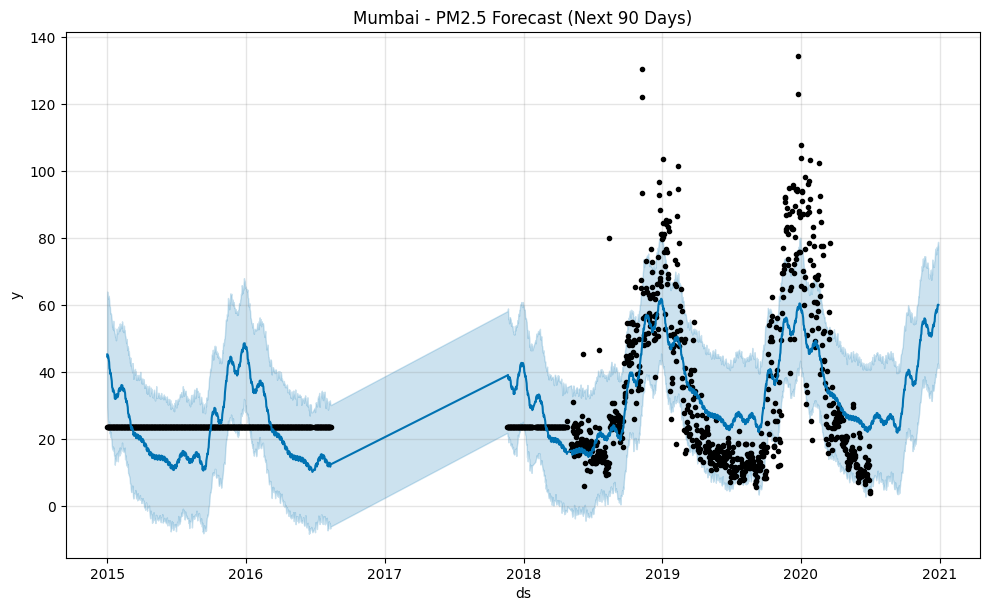

01:18:46 - cmdstanpy - INFO - Chain [1] start processing
01:18:47 - cmdstanpy - INFO - Chain [1] done processing


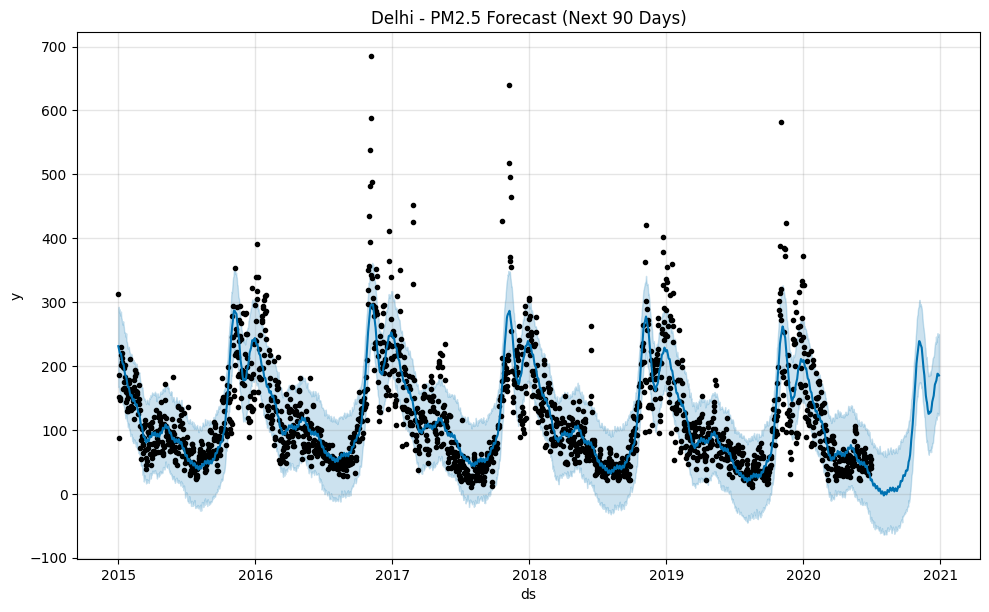

01:18:47 - cmdstanpy - INFO - Chain [1] start processing
01:18:48 - cmdstanpy - INFO - Chain [1] done processing


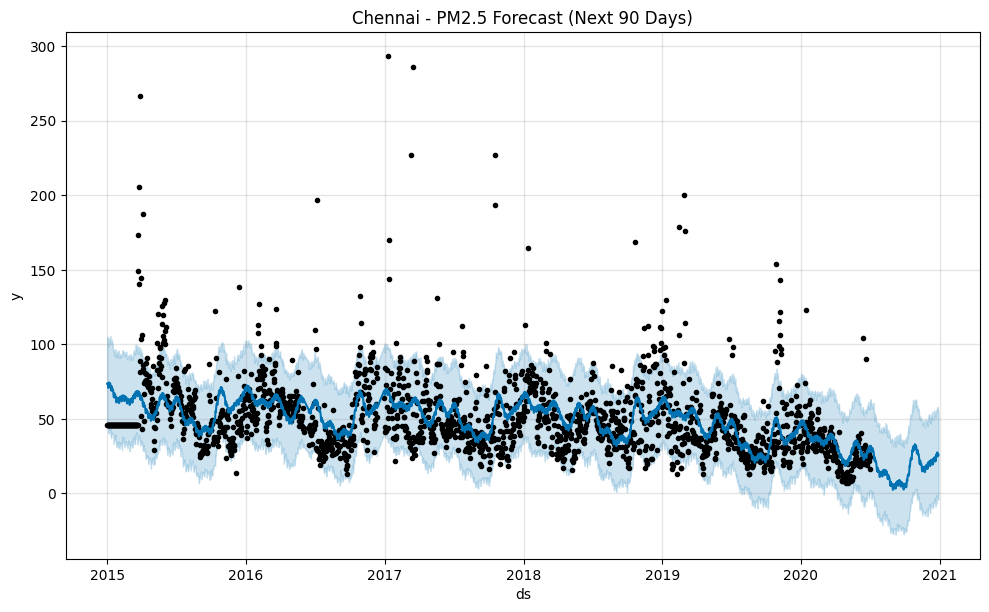

01:18:48 - cmdstanpy - INFO - Chain [1] start processing
01:18:49 - cmdstanpy - INFO - Chain [1] done processing


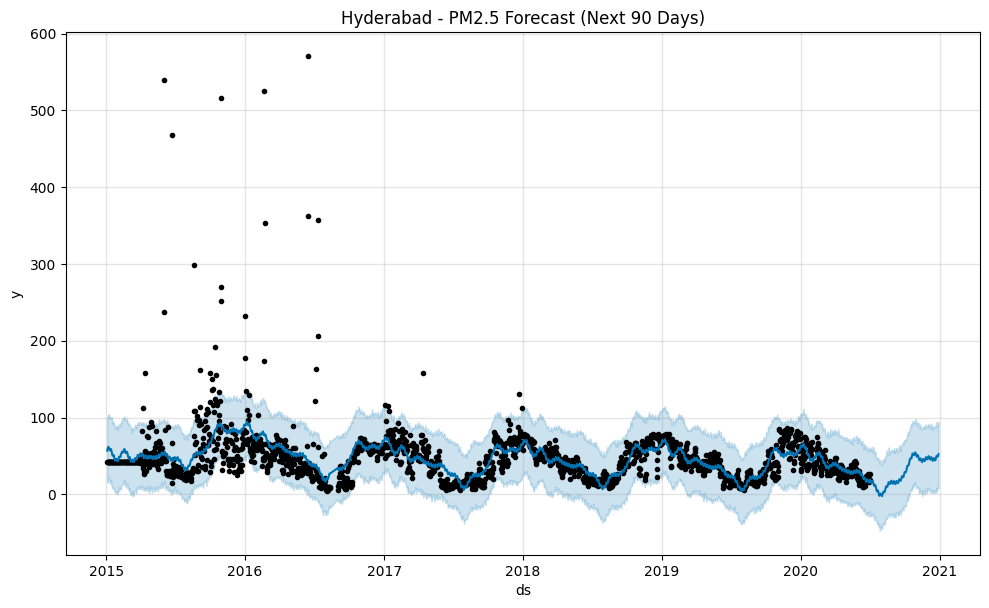

In [68]:
from prophet import Prophet
forecast_results = {}

for city in cities:
    city_data = df[df['city'] == city][['date', 'pm2_5']].dropna()

    if city_data.empty:
        print(f"[{city}] no rows for this city -> skipping")
        continue

    # Prepare for Prophet
    city_data = city_data.rename(columns={'date': 'ds', 'pm2_5': 'y'})

    # Prophet model
    model = Prophet(daily_seasonality=True, yearly_seasonality=True)
    model.fit(city_data)

    # Future dataframe (90 days ahead)
    future = model.make_future_dataframe(periods=180)
    forecast = model.predict(future)

    # Save forecast
    forecast_results[city] = forecast

    # Plot forecast
    fig = model.plot(forecast)
    plt.title(f"{city} - PM2.5 Forecast (Next 90 Days)")
    plt.show()

In [71]:

from sklearn.metrics import mean_absolute_error, mean_squared_error
test_size_ratio = 0.2  # last 20% for validation

# Example: df has 'date' and 'pm2_5'
df_city = df[df['city'] == 'Ahmedabad'][['date', 'pm2_5']].dropna()
df_city = df_city.sort_values('date')

# Train-test split
split_idx = int(len(df_city) * (1 - test_size_ratio))
train, test = df_city.iloc[:split_idx], df_city.iloc[split_idx:]

# -------------------
# 1. ARIMA
# -------------------
arima_model = ARIMA(train['pm2_5'], order=(5,1,2))  # tune p,d,q as needed
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=len(test))

arima_mae = mean_absolute_error(test['pm2_5'], arima_forecast)
arima_rmse = np.sqrt(mean_squared_error(test['pm2_5'], arima_forecast))
arima_mape = np.mean(np.abs((test['pm2_5'] - arima_forecast) / test['pm2_5'])) * 100

# -------------------
# 2. Prophet
# -------------------
prophet_train = train.rename(columns={'date': 'ds', 'pm2_5': 'y'})
prophet_test = test.rename(columns={'date': 'ds', 'pm2_5': 'y'})

prophet_model = Prophet()
prophet_model.fit(prophet_train)

future = prophet_model.make_future_dataframe(periods=len(test), freq='D')
forecast = prophet_model.predict(future)

# Get only forecasted part
prophet_forecast = forecast.iloc[-len(test):]['yhat'].values

prophet_mae = mean_absolute_error(test['pm2_5'], prophet_forecast)
prophet_rmse = np.sqrt(mean_squared_error(test['pm2_5'], prophet_forecast))
prophet_mape = np.mean(np.abs((test['pm2_5'] - prophet_forecast) / test['pm2_5'])) * 100

# -------------------
# Results
# -------------------
results = pd.DataFrame({
    'Model': ['ARIMA', 'Prophet'],
    'MAE': [arima_mae, prophet_mae],
    'RMSE': [arima_rmse, prophet_rmse],
    'MAPE (%)': [arima_mape, prophet_mape]
})

print(results)

01:19:47 - cmdstanpy - INFO - Chain [1] start processing
01:19:47 - cmdstanpy - INFO - Chain [1] done processing


     Model        MAE       RMSE   MAPE (%)
0    ARIMA  20.385962  25.884998  49.860402
1  Prophet  30.860061  37.339144  83.248108


In [72]:
warnings.filterwarnings("ignore")

# -------------------
# Config
# -------------------
test_size_ratio = 0.2  # last 20% for validation
target_column = 'pm2_5'
cities = ['Ahmedabad', 'Kolkata', 'Pune', 'Lucknow', 'Jaipur']  # pick any 5 cities

# -------------------
# Results storage
# -------------------
all_results = []

# -------------------
# Loop over cities
# -------------------
for city in cities:
    city_df = df[df['city'] == city][['date', target_column]].dropna().copy()
    city_df['date'] = pd.to_datetime(city_df['date'])
    city_df = city_df.sort_values('date')

    if len(city_df) < 50:
        print(f"[{city}] Not enough data, skipping")
        continue

    # Train-test split
    split_idx = int(len(city_df) * (1 - test_size_ratio))
    train, test = city_df.iloc[:split_idx], city_df.iloc[split_idx:]

    # -------------------
    # 1. ARIMA
    # -------------------
    try:
        arima_model = ARIMA(train[target_column], order=(5, 1, 2))
        arima_fit = arima_model.fit()
        arima_forecast = arima_fit.forecast(steps=len(test))

        arima_mae = mean_absolute_error(test[target_column], arima_forecast)
        arima_rmse = np.sqrt(mean_squared_error(test[target_column], arima_forecast))
        arima_mape = np.mean(np.abs((test[target_column] - arima_forecast) / test[target_column])) * 100
    except Exception as e:
        print(f"[{city}] ARIMA failed: {e}")
        arima_mae = arima_rmse = arima_mape = np.nan

    # -------------------
    # 2. Prophet
    # -------------------
    try:
        prophet_train = train.rename(columns={'date': 'ds', target_column: 'y'})
        prophet_test = test.rename(columns={'date': 'ds', target_column: 'y'})

        prophet_model = Prophet()
        prophet_model.fit(prophet_train)

        future = prophet_model.make_future_dataframe(periods=len(test), freq='D')
        forecast = prophet_model.predict(future)

        # Take only forecast for the test period
        prophet_forecast = forecast.iloc[-len(test):]['yhat'].values

        prophet_mae = mean_absolute_error(test[target_column], prophet_forecast)
        prophet_rmse = np.sqrt(mean_squared_error(test[target_column], prophet_forecast))
        prophet_mape = np.mean(np.abs((test[target_column] - prophet_forecast) / test[target_column])) * 100
    except Exception as e:
        print(f"[{city}] Prophet failed: {e}")
        prophet_mae = prophet_rmse = prophet_mape = np.nan

    # Append results
    all_results.append({
        'City': city,
        'Model': 'ARIMA',
        'MAE': arima_mae,
        'RMSE': arima_rmse,
        'MAPE (%)': arima_mape
    })
    all_results.append({
        'City': city,
        'Model': 'Prophet',
        'MAE': prophet_mae,
        'RMSE': prophet_rmse,
        'MAPE (%)': prophet_mape
    })

# -------------------
# Combine results
# -------------------
results_df = pd.DataFrame(all_results)
print(results_df)

# Optional: Compare averages across cities
avg_results = results_df.groupby('Model')[['MAE', 'RMSE', 'MAPE (%)']].mean().reset_index()
print("\nAverage performance across all cities:")
print(avg_results)


01:21:34 - cmdstanpy - INFO - Chain [1] start processing
01:21:34 - cmdstanpy - INFO - Chain [1] done processing
01:21:35 - cmdstanpy - INFO - Chain [1] start processing
01:21:35 - cmdstanpy - INFO - Chain [1] done processing


[Pune] Not enough data, skipping


01:21:36 - cmdstanpy - INFO - Chain [1] start processing
01:21:36 - cmdstanpy - INFO - Chain [1] done processing
01:21:37 - cmdstanpy - INFO - Chain [1] start processing
01:21:37 - cmdstanpy - INFO - Chain [1] done processing


        City    Model         MAE        RMSE    MAPE (%)
0  Ahmedabad    ARIMA   20.385962   25.884998   49.860402
1  Ahmedabad  Prophet   30.860061   37.339144   83.248108
2    Kolkata    ARIMA   55.637582   62.165538         NaN
3    Kolkata  Prophet  105.451440  118.189818  628.599113
4    Lucknow    ARIMA   44.924983   56.445576         NaN
5    Lucknow  Prophet   24.570479   35.400347   35.062300
6     Jaipur    ARIMA   22.976793   26.480209         NaN
7     Jaipur  Prophet   11.520987   14.211204   33.439373

Average performance across all cities:
     Model        MAE       RMSE    MAPE (%)
0    ARIMA  35.981330  42.744080   49.860402
1  Prophet  43.100742  51.285128  195.087223


In [65]:
df["PM25_exceed"] = df["pm2_5"] > 60

# Calculate % exceedance per city
risk_by_city = df.groupby("city")["PM25_exceed"].mean().reset_index()
risk_by_city["exceed_percent"] = risk_by_city["PM25_exceed"] * 100
risk_by_city = risk_by_city.sort_values("exceed_percent", ascending=False)

print(risk_by_city.head(10))

            city  PM25_exceed  exceed_percent
16    Jorapokhar     0.800434       80.043384
12      Gurugram     0.741656       74.165637
10         Delhi     0.725461       72.546089
21         Patna     0.704217       70.421687
19       Lucknow     0.681407       68.140704
6   Brajrajnagar     0.527778       52.777778
0      Ahmedabad     0.470213       47.021277
13      Guwahati     0.404382       40.438247
18       Kolkata     0.368550       36.855037
23       Talcher     0.348635       34.863524


In [66]:
monthly_avg = df.groupby("month")["pm2_5"].mean().reset_index()
monthly_avg = monthly_avg.sort_values("pm2_5", ascending=False)
print(monthly_avg)

    month       pm2_5
10     11  107.488052
11     12  105.913336
0       1  100.231306
1       2   79.024244
9      10   72.000114
2       3   61.878251
3       4   51.700209
4       5   50.744066
5       6   44.008355
6       7   39.182980
8       9   38.815257
7       8   35.863431
